# PIR - LSTM n°4: Attempt with validation data

This notebook implements a dedicated prediction pipeline using optimal hyperparameters identified via Optuna. The goal is to forecast station affluence based on calendar patterns.\\
Key Features:
* **Feature Set:** Non-autoregressive approach using only ['job', 'ferie', 'vacances'],
* **Optimization:** Architecture powered by tuned hyperparameters from `OptimizeParameters4.ipynb`,
* **Local Modeling:** Each station is modeled independently, with a unique LSTM trained on its specific historical data,
* **Data Cleaning:** The COVID-19 period is excluded to maintain focus on representative passenger behavior,
* **Handling Exceptions:** Recent stations with limited history are treated separately,
* **Uniform Sampling:** Sequences are generated using a uniform random distribution to ensure full temporal coverage while optimizing training speed.

## 1: Imports

In [1]:
# Custom utility functions used in the project
import utils
import modelsV2 # Uniform sequences + Random split for validation data

import importlib

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2026-01-13 19:28:30.976010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 19:28:31.026971: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 19:28:33.710726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# In case of 'utils.py' modifications
importlib.reload(utils)

<module 'utils' from '/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/utils.py'>

In [31]:
# In case of 'modelsV2.py' modifications
importlib.reload(modelsV2)

<module 'modelsV2' from '/home/pedoussa/Bureau/PIR 5A _ 13-01-2026/modelsV2.py'>

## 2: Model Validation on 2022 data

### 2.1: Data Preparation

In [2]:
# Load the data
x = pd.read_csv('train_f_x.csv')
y = pd.read_csv('y_train_sncf.csv')

In [3]:
# Data preparation
df_per_station_train, df_per_station_test = utils.prepare_backtest_data(x, y, remove_covid=True)

### 2.2: Sampling

In [4]:
# Create a sample of stations
sample_size = 10
seed = 56

# train
sample_train = utils.sample_stations(df_per_station_train, sample_size, seed)
print("sample_train: ", sample_train.keys())

# test
sample_test = {
    station: df_per_station_test[station]
    for station in sample_train.keys()
}

print("sample_test: ", sample_test.keys())

sample_train:  dict_keys(['UMC', '09U', '4PO', 'Y5A', '6WR', 'YJK', 'P3G', 'TEP', '9WY', 'KA0'])
sample_test:  dict_keys(['UMC', '09U', '4PO', 'Y5A', '6WR', 'YJK', 'P3G', 'TEP', '9WY', 'KA0'])


In [5]:
# Keep true values 
sample_test_true = {
    station: df_per_station_test[station].copy()
    for station in sample_train.keys()
}

### 2.3: Predictions

In [ ]:
# Best params found: {'units': 64, 'learning_rate': 0.009172885794840763, 'batch_size': 16, 'seq_len': 120}

# Parameters
seq_len = 120
units = 64
activation = 'tanh'
learning_rate = 0.0005
batch_size = 16

# Epochs
epochs = 15

In [7]:
# Execution flag
run_experiment = 1

In [19]:
# Execution (chronological validation data)
if (run_experiment == 1):
    # Run
    sample_test_1, mape_results_1, all_losses_1 = modelsV2.lstm_model(sample_train, sample_test, sample_test_true,
                                                                      sample_size, seq_len, units, activation, learning_rate, batch_size,
                                                                      epochs=epochs, early_stop = True,
                                                                      features = ['job', 'ferie', 'vacances'])

1/10 Station UMC
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/10 Station 09U
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/10 Station 4PO
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/10 Station Y5A
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/10 Station 6WR
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/10 Station YJK
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/10 Station P3G
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/10 Station TEP
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/10 Station 9WY
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 Station KA0
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


### 2.4: Explore Results

In [20]:
# Display MAPE results
utils.show_mape_results(mape_results_1)

MAPE per station:
  station      MAPE
0     UMC  0.309820
1     09U  6.489792
2     4PO  0.328115
3     Y5A  0.225856
4     6WR  0.475008
5     YJK  0.415666
6     P3G  0.330060
7     TEP  0.593720
8     9WY  0.257497
9     KA0  0.210677

Average MAPE over all stations: 0.9636


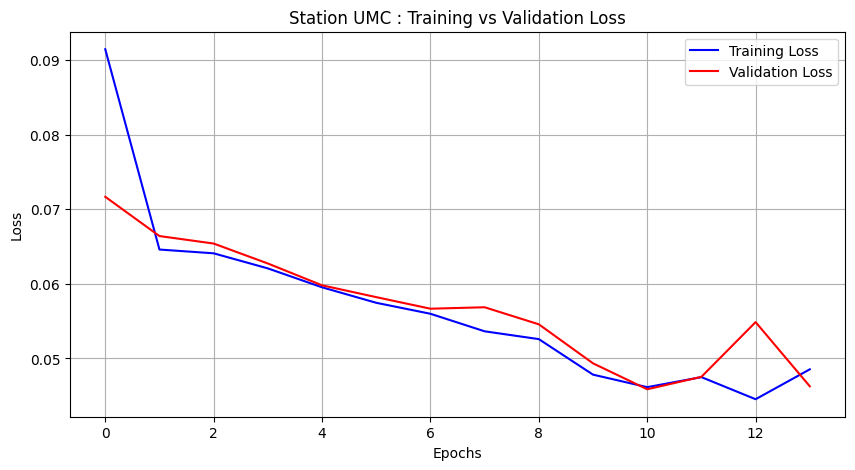

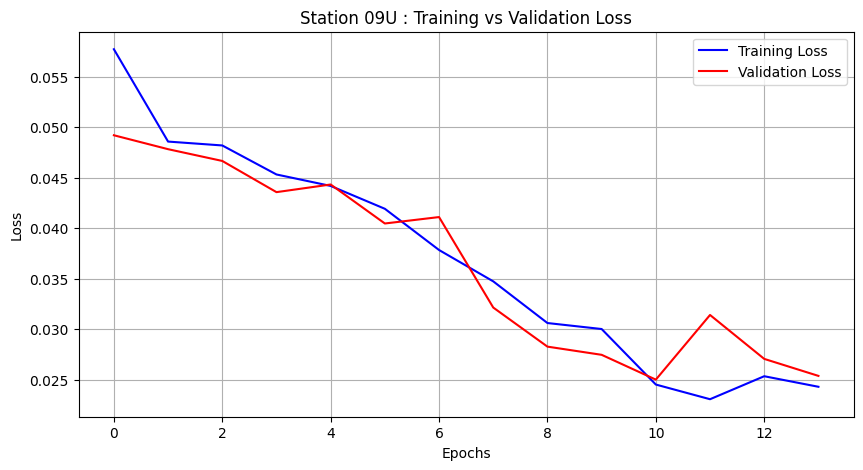

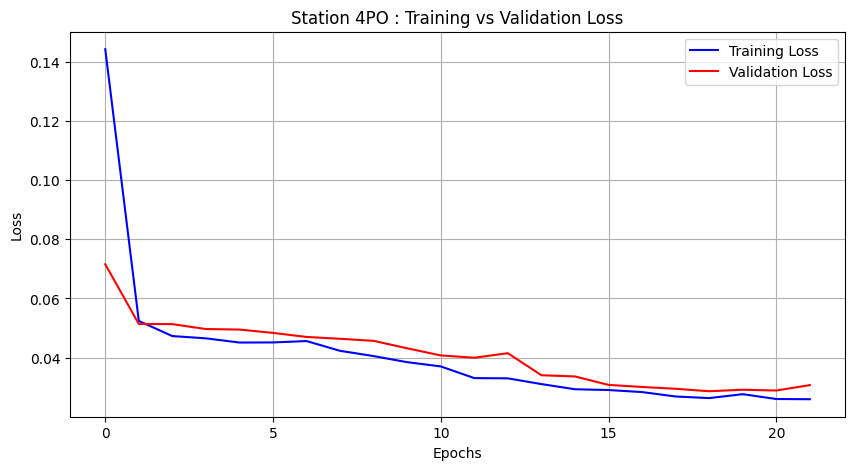

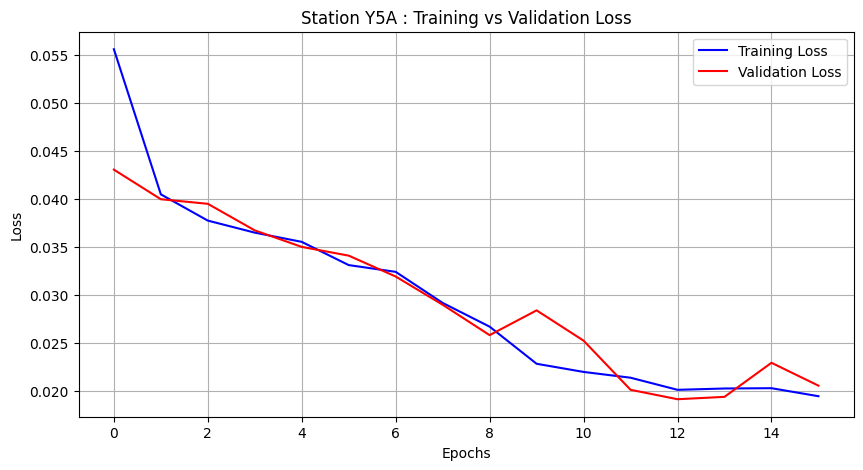

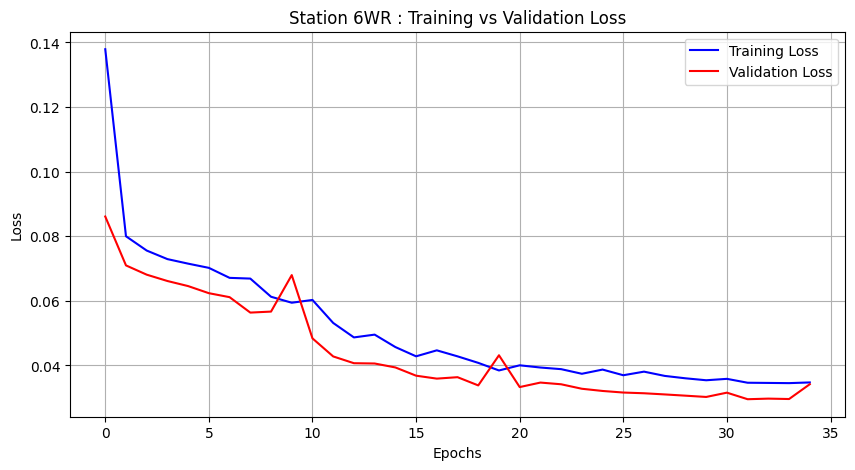

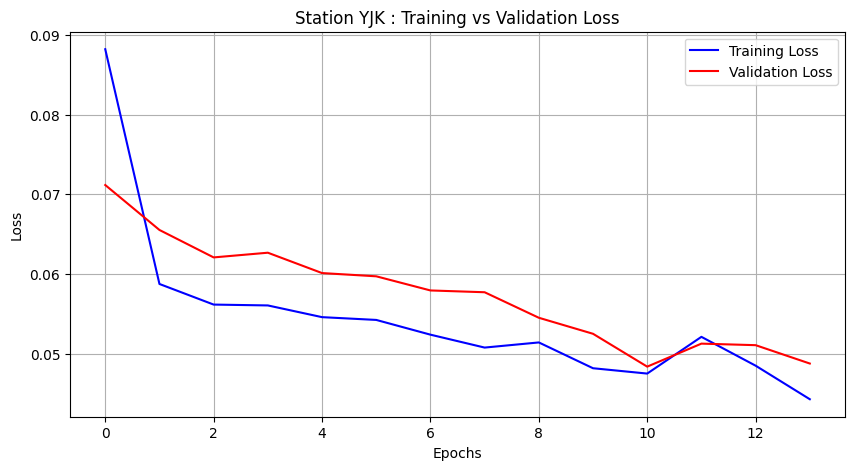

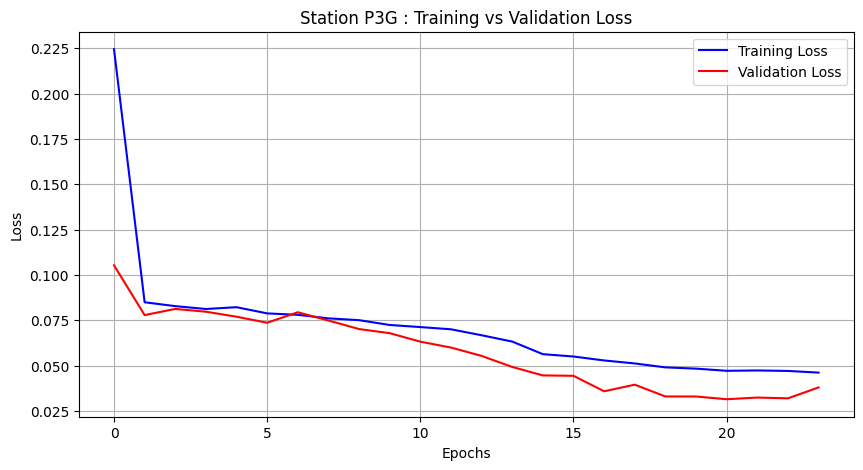

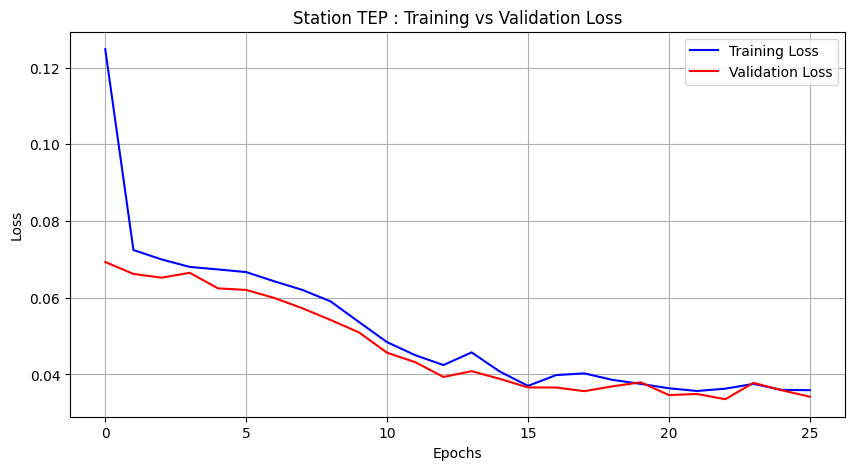

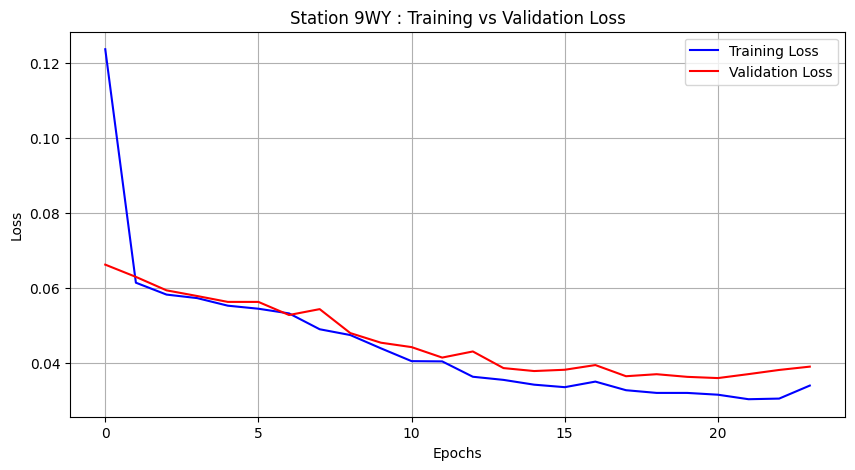

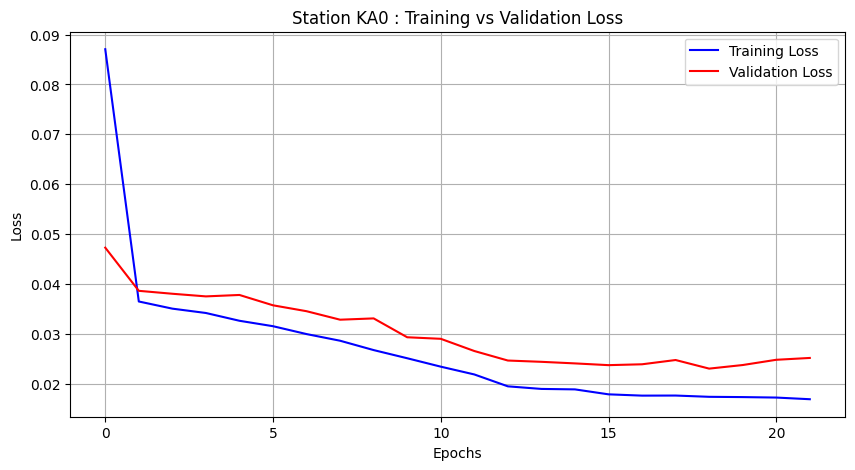

In [21]:
# Display losses for the sample
for station_name, history in all_losses_1.items():
    utils.plot_training_loss(
        history['train'], 
        history['val'], 
        title=f"Station {station_name} : Training vs Validation Loss"
    )

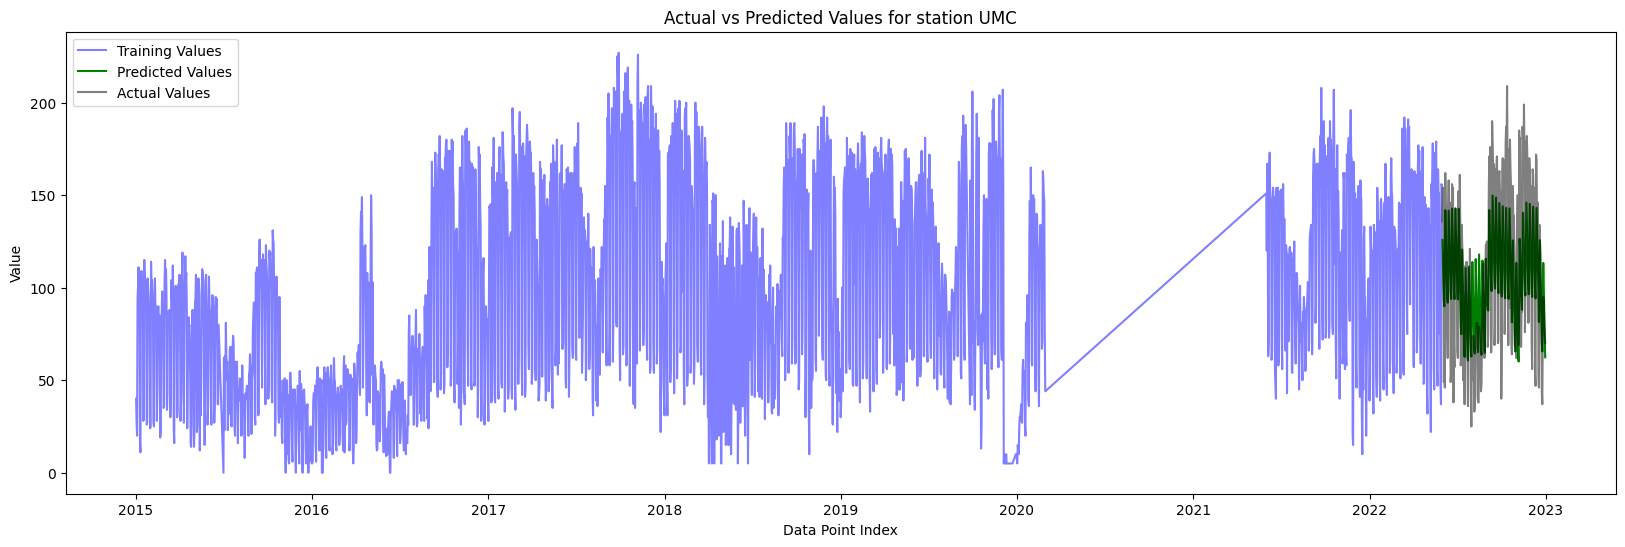

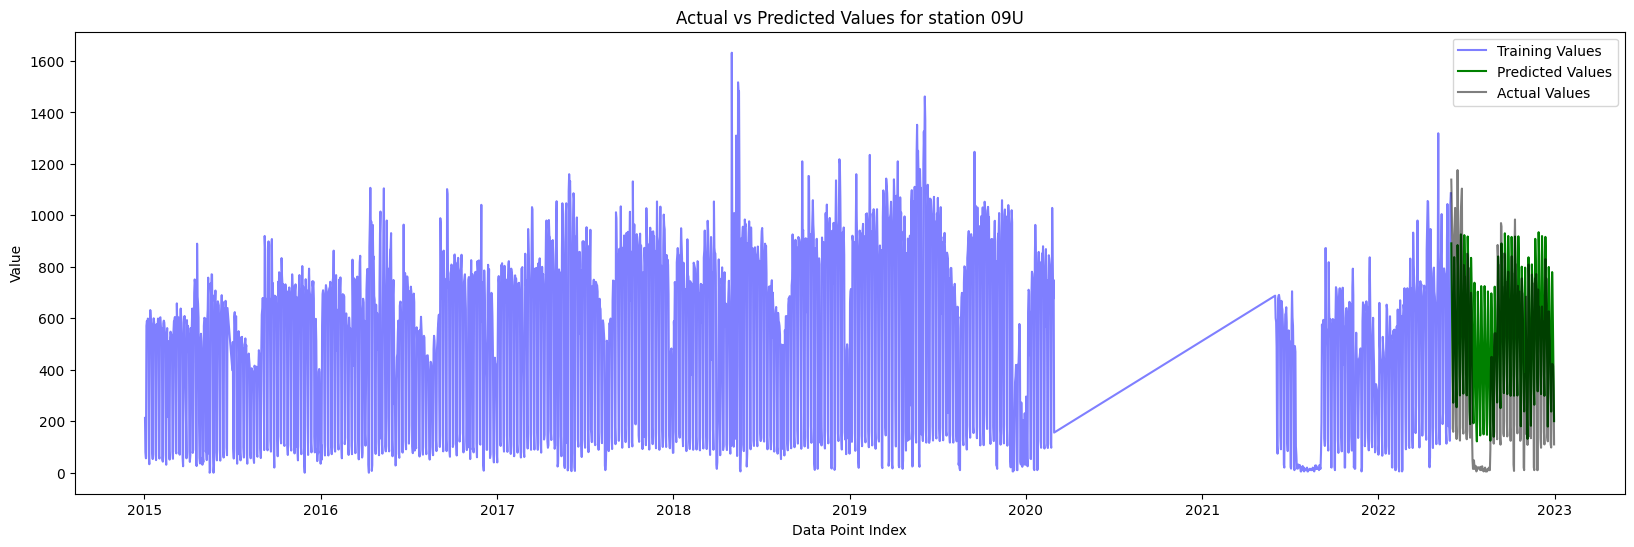

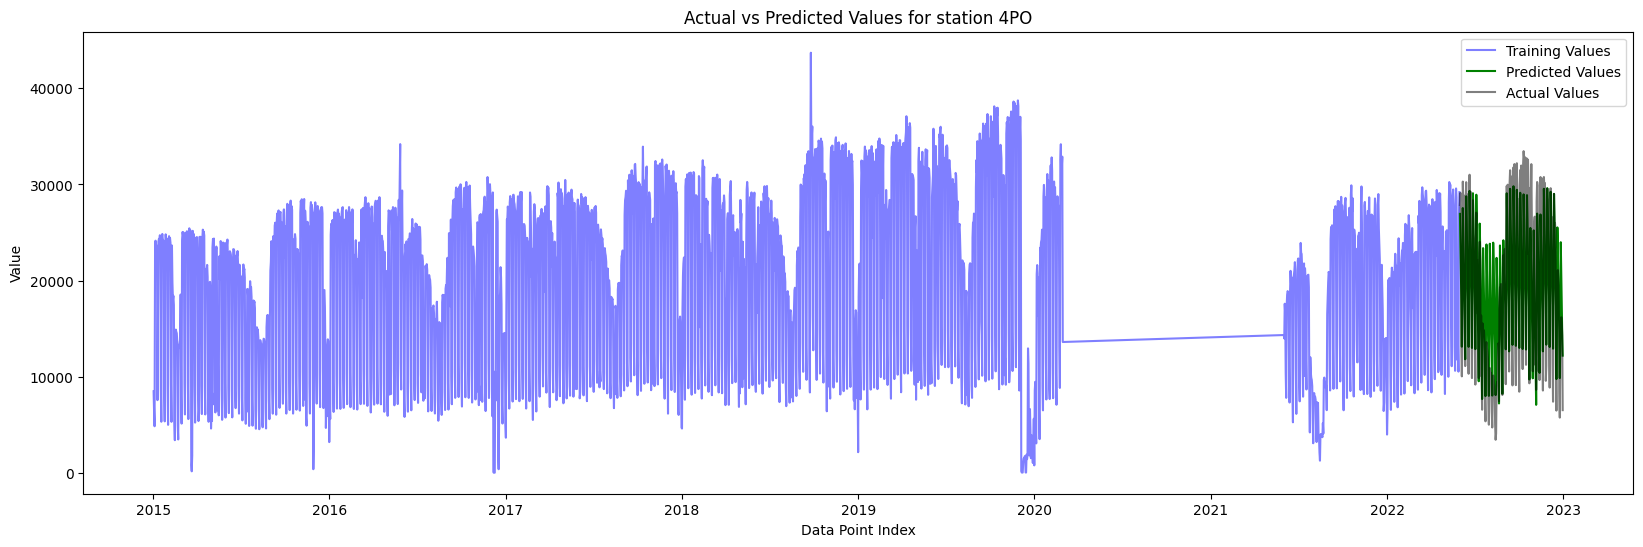

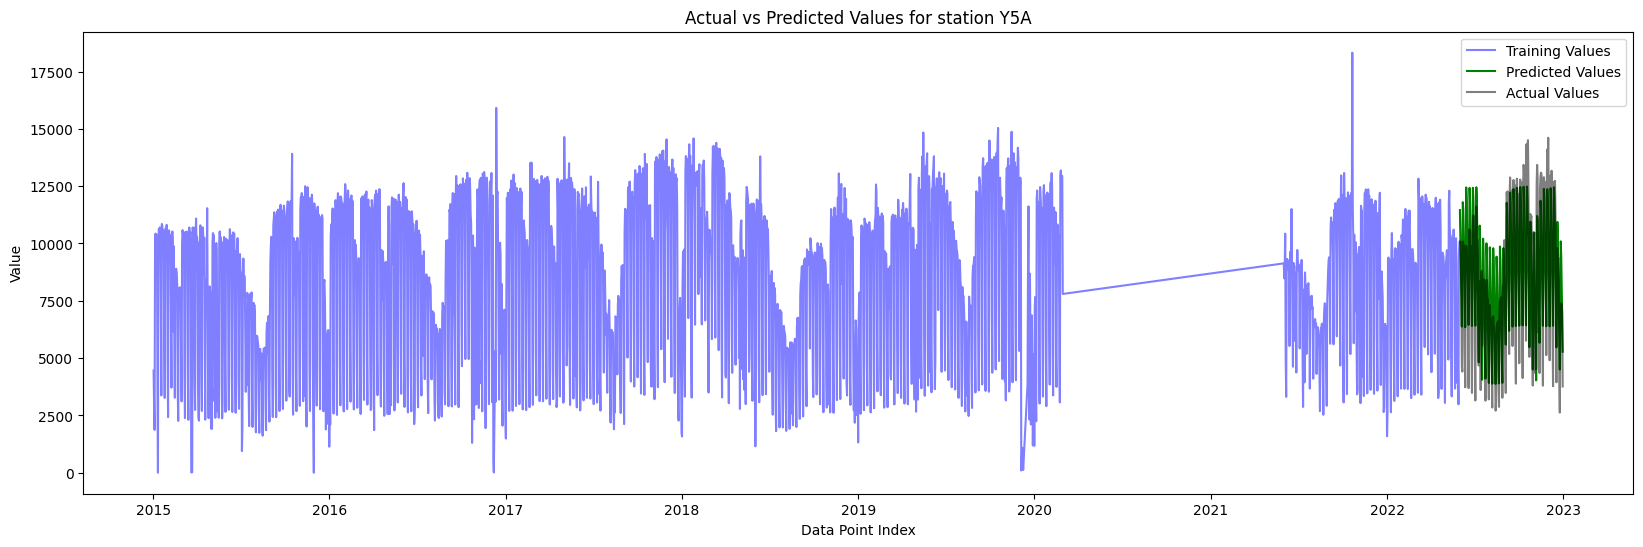

In [22]:
# Display predictions for the sample
idx=1
for station in sample_train.keys():
    if (idx<=4):
        utils.show_predictions_results_one_station(sample_train,
                                sample_test_1,
                                sample_test_true,
                                station)      
    idx+=1

---

## 3: Attempt for submission

### 3.1: Data Preparation

In [23]:
# Load the data
x_train = pd.read_csv('train_f_x.csv')
y_train = pd.read_csv('y_train_sncf.csv')
x_test = pd.read_csv('x_test.csv')

In [25]:
# Create test and train dictionnaries per station
df_established_train, df_recent_train, df_established_test, df_recent_test = utils.prepare_submission_data(x_train, y_train, x_test, remove_covid=True)

In [26]:
# Create y_predicted_v4 to store predictions
y_predicted_v4 = utils.create_y_attempt(x_test)

### 3.2: Prediction for 'QD6' station

In [27]:
# Best params found: {'units': 64, 'learning_rate': 0.009172885794840763, 'batch_size': 16, 'seq_len': 120}

# Parameters
seq_len = 120
units = 64
activation = 'tanh'
learning_rate = 0.0005
batch_size = 16

# Epochs
epochs = 15

In [28]:
y_predicted_vX, all_losses = modelsV2.lstm_submission_prediction_all(df_established_train, df_established_test,
                                                                     y_predicted_v4,
                                                                     seq_len, units, activation, learning_rate, batch_size,
                                                                     epochs, early_stop = True,
                                                                     features = ['job', 'ferie', 'vacances'])

1/434 Station 1J7
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/434 Station WDP
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/434 Station SWS
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/434 Station S3E
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/434 Station RDK
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/434 Station I9U
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/434 Station OM7
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/434 Station 09U
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/434 Station 0S9
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/434 Station KO0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/434 Station 4WI
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/434 Station 23N
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/434 Station WVV
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/434 Station TFW
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
15/434 Station L6F
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/434 Station X3T
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
17/434 Station I8D
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
18/434 Station EOE
6/6 ━━━━━━━━━━━━━━━━━

### 3.3: Prediction for the recent stations

In [29]:
# Parameters
seq_len = 20
units = 32
activation = 'tanh'
learning_rate = 0.009866
batch_size = 32

# Epochs
epochs = 15

In [32]:
y_predicted_vX, all_losses = modelsV2.lstm_submission_prediction_recent(df_recent_train, df_recent_test,
                                                                     y_predicted_vX,
                                                                     seq_len, units, activation, learning_rate, batch_size,
                                                                     epochs, early_stop = True,
                                                                     features = ['job', 'ferie', 'vacances'])

1/5 Station W14


2026-01-13 20:26:38.814491: I external/local_xla/xla/service/service.cc:163] XLA service 0x722bdc325830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-13 20:26:38.814527: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation, Compute Capability 8.9
2026-01-13 20:26:39.096640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1768332400.676419 1177509 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
2/5 Station BDC
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3/5 Station P6E
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
4/5 Station W80
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
5/5 Station QD6
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step


In [33]:
y_predicted_vX.to_csv('y_test_LSTM_v4.csv', index=False)

In [34]:
# Reorder for submission
y_test_example = pd.read_csv('y_test_exemple.csv')
y_test_v4 = pd.read_csv('y_test_LSTM_v4.csv')
y_test_sorted = utils.reorder_for_submission(y_test_v4, y_test_example)
y_test_sorted.to_csv('y_test_LSTM_v4TEST_sorted.csv', index=False)

In [ ]:
# Submission results: 
# Your score for this submission is: 

## 4: Explore Results

In [35]:
# Re-load data
x_test=pd.read_csv('x_test.csv')
y_test_v4 = pd.read_csv('y_test_LSTM_v4.csv')

In [40]:
# Data preparation
df_established_predicted, df_recent_predicted = utils.prepare_results_data(x_test, y_test_v4)

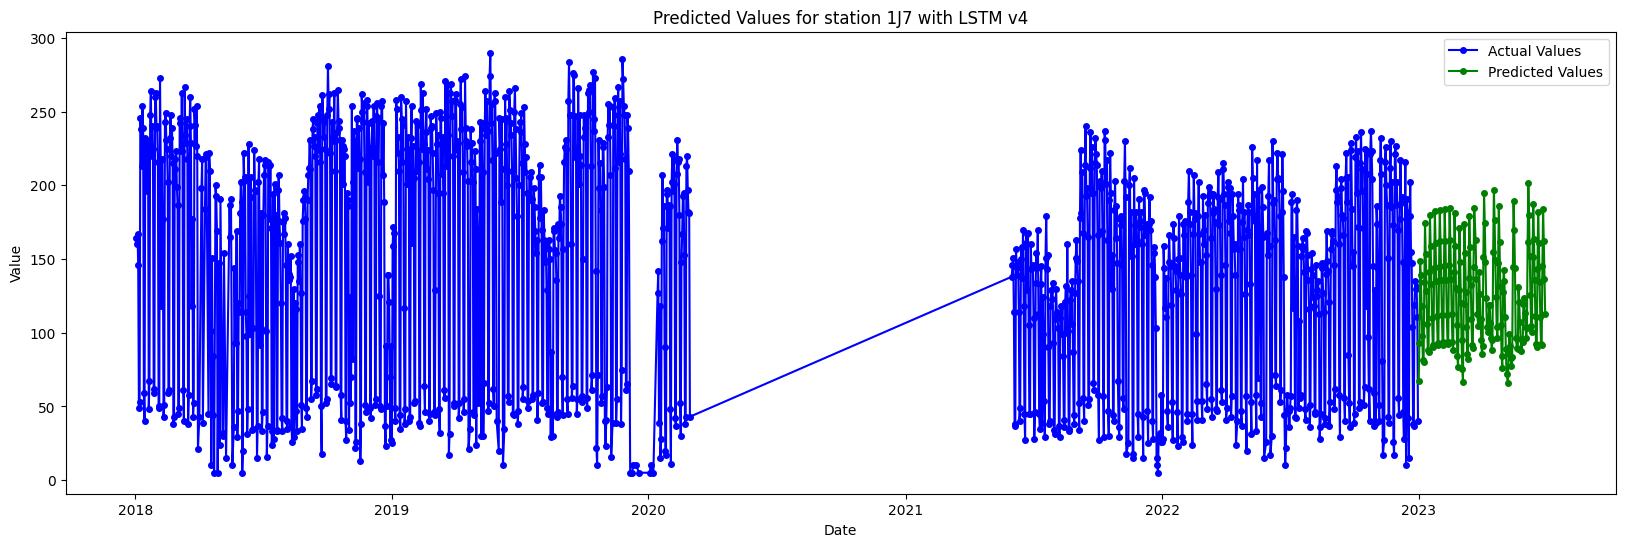

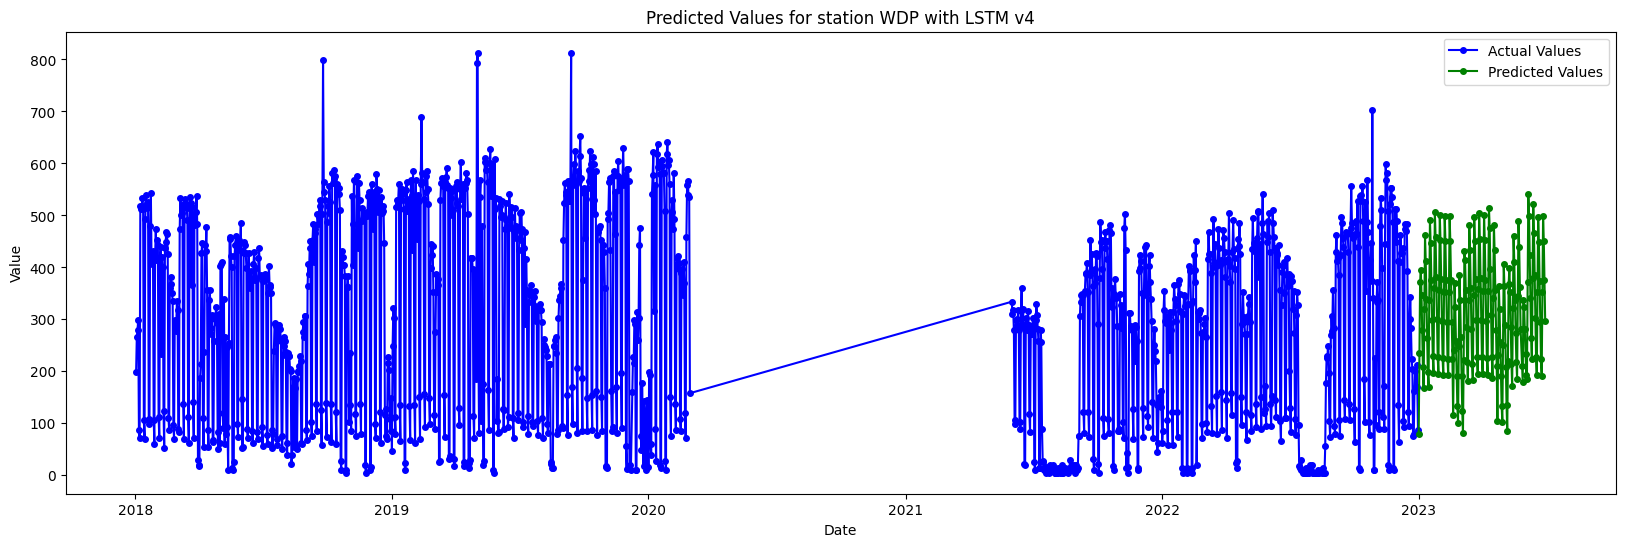

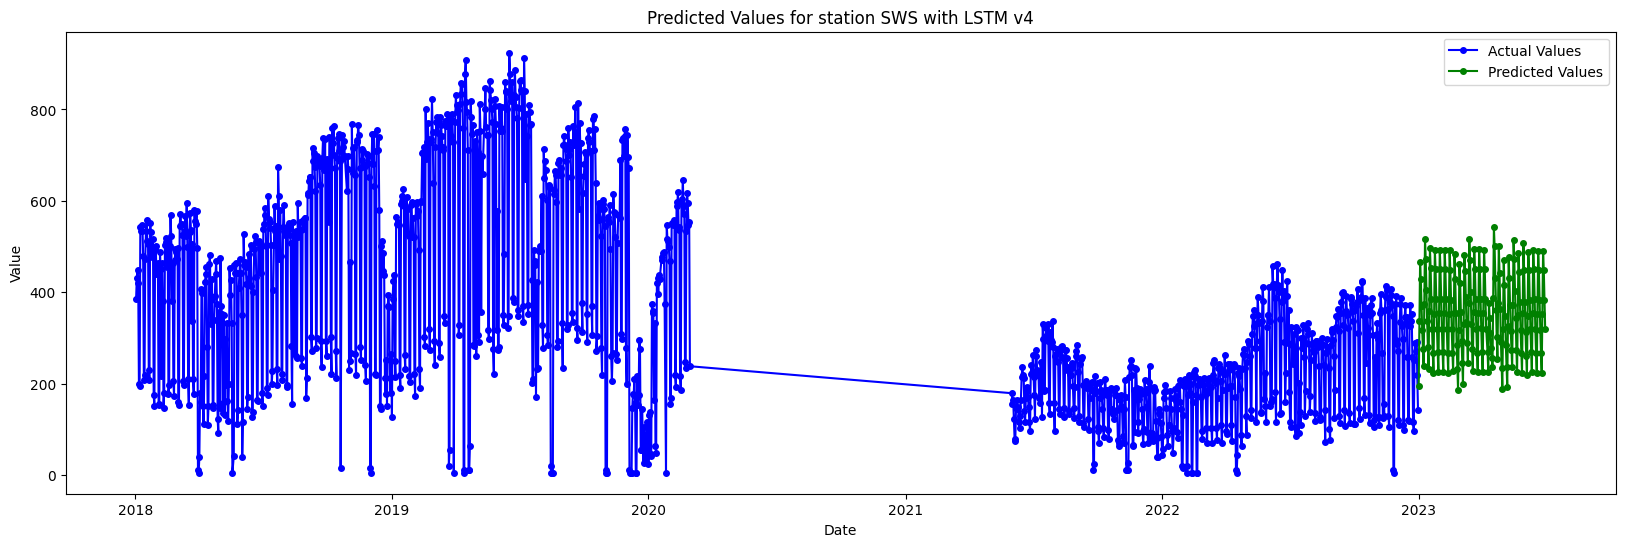

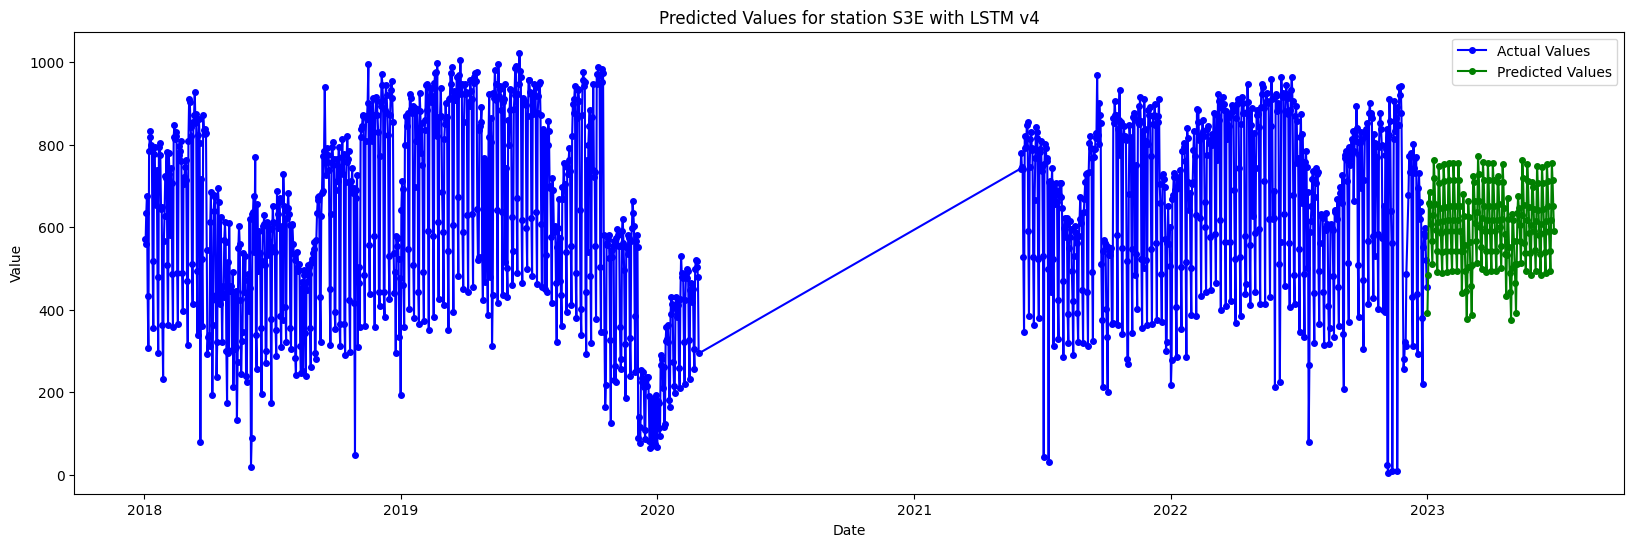

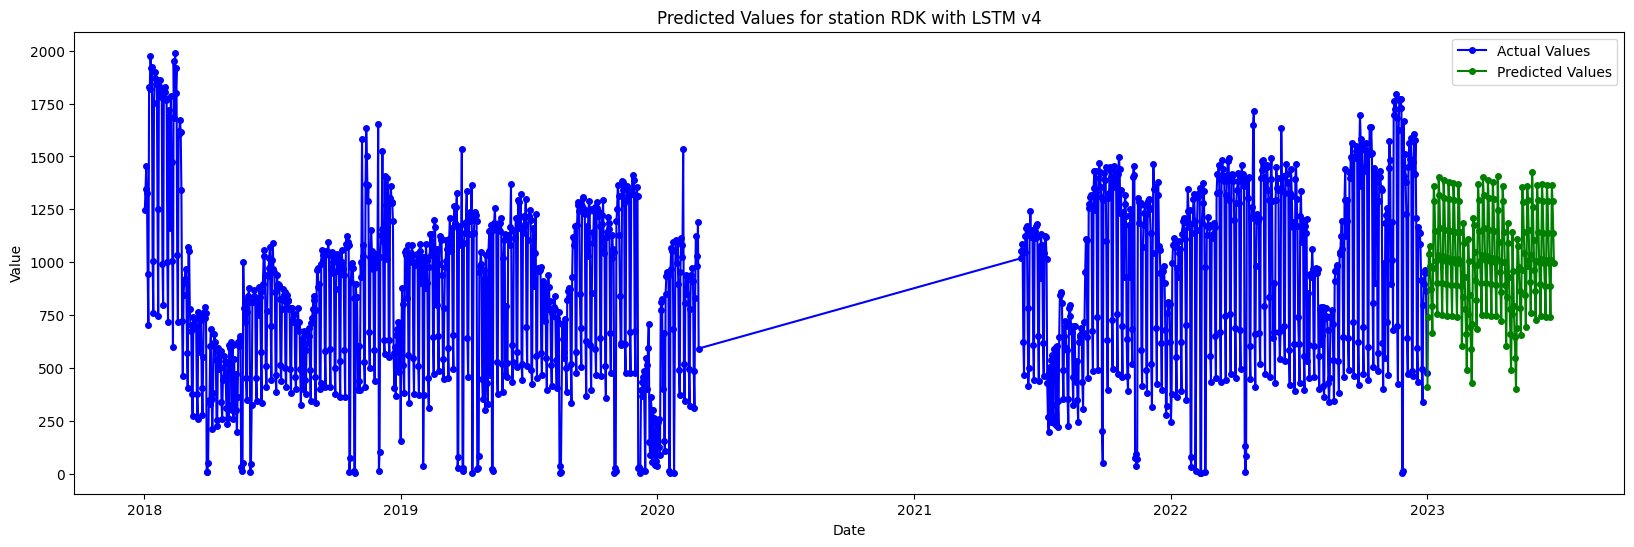

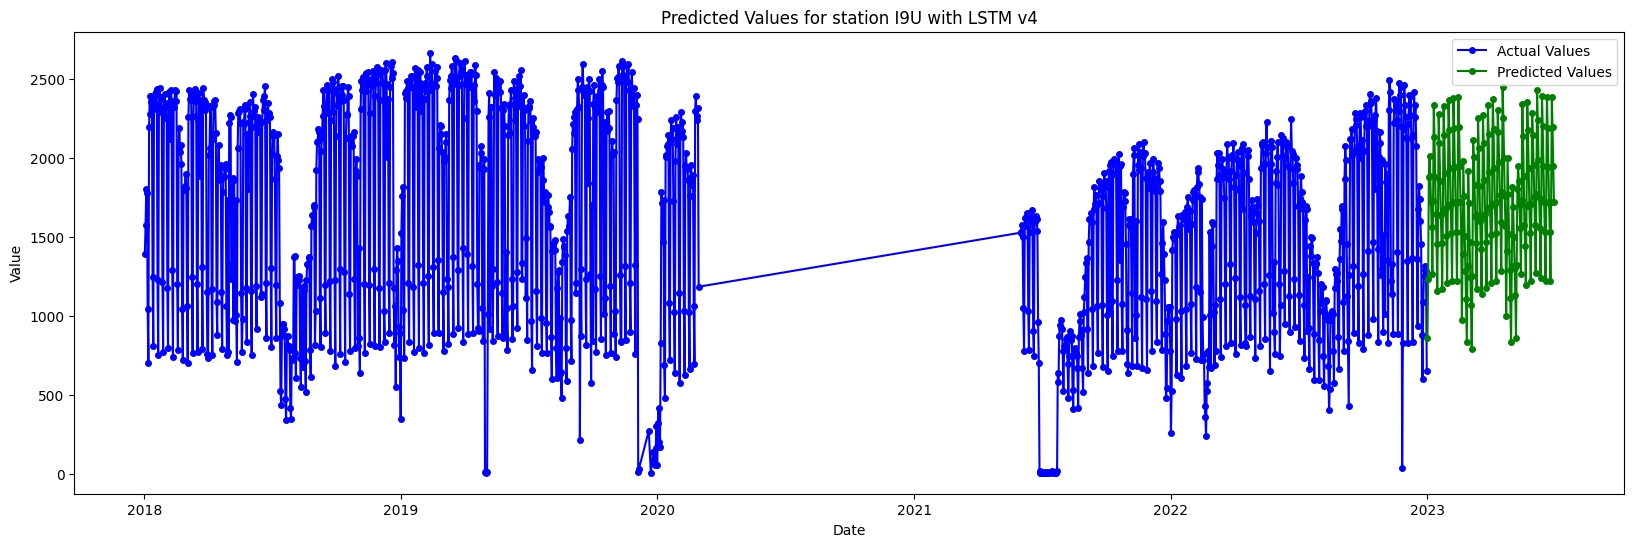

In [43]:
# Show predicted values for few stations
idx=9
for station in df_established_predicted:
    if (idx >= 15):
            break
    else:
        utils.show_prediction(df_established_train,   # df_train
                                    df_established_predicted,     # df_test
                                    station,          # station_name
                                    'LSTM v4',        # model_name
                                    '2018-01-01')     # start_date
    idx+=1    